## Installing Weights and Biases Dash Board

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 42.7 MB/s 
     |████████████████████████████████| 181 kB 44.4 MB/s 
     |████████████████████████████████| 63 kB 854 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c0db0760beb054d03ff6de95fd54f5a0b6d9c96485b14949f9aa3d1b85b1039c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optimizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb

## Data Analysis

In [4]:
df = pd.read_csv("/content/WHO-COVID-19-india-data_.csv",index_col = "Date_reported", parse_dates=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 739 entries, 2020-01-03 to 2022-01-10
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         739 non-null    int64 
 1   Country_code       739 non-null    object
 2   Country            739 non-null    object
 3   WHO_region         739 non-null    object
 4   New_cases          739 non-null    int64 
 5   Cumulative_cases   739 non-null    int64 
 6   New_deaths         739 non-null    int64 
 7   Cumulative_deaths  739 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 52.0+ KB


In [6]:
df.head()

,Unnamed: 0,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,,
2020-01-03,73344,IN,India,SEARO,0,0,0,0
2020-01-04,73345,IN,India,SEARO,0,0,0,0
2020-01-05,73346,IN,India,SEARO,0,0,0,0
2020-01-06,73347,IN,India,SEARO,0,0,0,0
2020-01-07,73348,IN,India,SEARO,0,0,0,0


## Plotting the graph of first two Covid-19 Waves in India

In [7]:
df_cases = df[["New_cases"]]

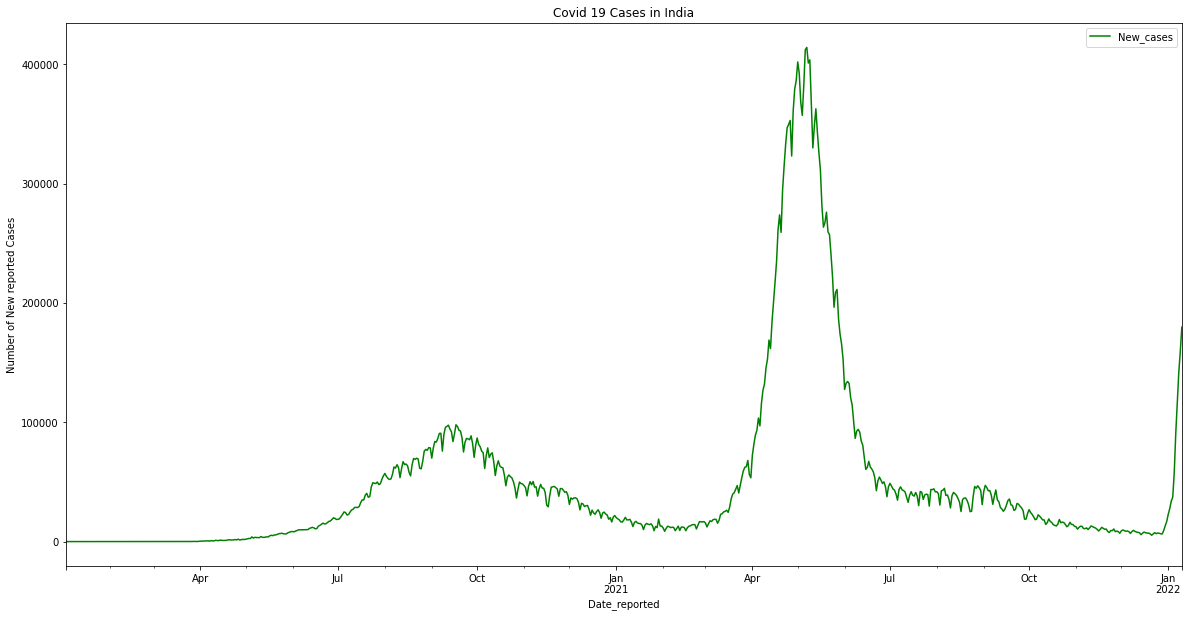

In [8]:
df_cases.plot(color = "Green",figsize = (20,10), title = "Covid 19 Cases in India", ylabel = "Number of New reported Cases")

## Standardizing Data to speed up LSTM Training

In [9]:
scaler = StandardScaler()

## Custom DataLoader to generate Time Series Data

In [10]:
class TimeSeriesDatset(Dataset):
  def __init__(self, dataframe, time_step):
    self.time_step = time_step - 1
    self.X = torch.tensor(scaler.fit_transform(dataframe)).float()

  def __getitem__(self, index):
    if index > self.time_step - 1:
      index_start = index - self.time_step
      x = self.X[index_start:index,:]
    else:
      padding = self.X[0].repeat(self.time_step - index,1)
      x = self.X[0:index,:]
      x = torch.cat((padding, x),0)
    return x,self.X[index]

  def __len__(self):
    return self.X.shape[0]

## Training Loop

In [12]:
def train(args, model, device, train_loader, optimizer, epoch):
    print("Epoch:",epoch)
    train_loss = 0
    model.train()  # setting model to train mode
    for features, targets in train_loader:  # trainloader returns a tuple -> (batch of features with time steps, corresponding vector of targets)
        # Feed-forward Section
        features = features.to(device)  # shift features to GPU for faster training
        targets = targets.to(device)  # shift targets to GPU for faster training
        outputs = model(features)  # output of LSTM neural network
        # Back-propagation Section
        loss = F.mse_loss(outputs, targets)  # calculate the mean squared loss per batch of the features
        train_loss+=loss.item()
        optimizer.zero_grad()  # set the gradients matrix to zero before calculating the gradients for every batch
        loss.backward()  # calculate the gradients through differentiation (dL/dW)
        optimizer.step()  # update of weights (w = w - dL/dW)
    ### Log results to the Wandb Dashbaord
    wandb.log({
        "Train Loss": train_loss})

## LSTM Neural Network Architecture

In [14]:
class LSTM(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.num_features = num_features
    # self.hidden_units = hidden_units
    self.num_layers = 1


    self.lstm = nn.LSTM(
        input_size = num_features,
        hidden_size = 10,
        batch_first = True,
        num_layers = self.num_layers
    )
    self.lstm2 = nn.LSTM(
        input_size = 10,
        hidden_size = 20,
        batch_first = False,
        num_layers = self.num_layers
    )
    self.lstm3 = nn.LSTM(
        input_size = 20,
        hidden_size = 10,
        batch_first = False,
        num_layers = self.num_layers
    )
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.4)
    self.dropout2 = nn.Dropout(0.2)
    self.linear = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    batch_size = x.shape[0]
    h0 = torch.zeros(self.num_layers, batch_size, 10).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, 10).to(device)

    h1 = torch.zeros(self.num_layers, batch_size, 20).to(device)
    c1 = torch.zeros(self.num_layers, batch_size, 20).to(device)

    h2 = torch.zeros(self.num_layers, batch_size, 10).to(device)
    c2 = torch.zeros(self.num_layers, batch_size, 10).to(device)

    _, (hn, _) = self.lstm(x, (h0, c0))
    hn = self.dropout1(self.relu(hn))
    _, (hn, _) = self.lstm2(hn, (h1, c1))
    hn = self.dropout2(self.relu(hn))
    _, (hn, _) = self.lstm3(hn, (h2, c2))
    hn = self.dropout2(self.relu(hn))
    out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

    return out

## Setting Hyperparameters

In [15]:
# WandB – Initialize a new run
wandb.init(entity="ajinkya98", project="pytorch-covid19-time_series_prediction")
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config  # Initialize config
config.batch_size = 1  # input batch size for training (default: 64)
# config.test_batch_size = 32  # input batch size for testing (default: 1000)
config.epochs = 50  # number of epochs to train (default: 10)
config.lr = 0.001  # learning rate (default: 0.01)
config.timestep = 50
# config.hidden_units = 50
# config.num_layers = 1
config.no_cuda = False  # disables CUDA training
config.seed = 42  # random seed (default: 42)
config.log_interval = 10  # how many batches to wait before logging training status

train_dataset = TimeSeriesDatset(df_cases, config.timestep + 1)
# test_dataset = CustomImageDataset("Image Classification Data/data/test")

wandb: Currently logged in as: ajinkya98 (use `wandb login --relogin` to force relogin)


## Running Training Module

In [16]:
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# Set random seeds and deterministic pytorch for reproducibility
# random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed)  # pytorch random seed
# numpy.random.seed(config.seed) # numpy random seed
torch.backends.cudnn.deterministic = True

# Now we load our training and test datalaoders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False, **kwargs)
# test_loader = DataLoader(test_dataset, batch_size=config.test_batch_size, shuffle=True, **kwargs)

## model:
# model = LSTM(1,config.hidden_units,config.num_layers)
model = LSTM(1)

## Optimizer Adam Initialization
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

# WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(model, log="all")

## Initializing the train and test loops:
for epoch in range(1, config.epochs + 1):
    train(config, model, device, train_loader, optimizer, epoch)
    # test(config, model, device, test_loader, classes)

# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.[Comment others if using this]
torch.save(model.state_dict(), "lstm_reg.h5")
wandb.save("lstm_reg.h5")

Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()


Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


['/content/wandb/run-20220425_232650-2rilq96b/files/lstm_reg.h5']

## Generating predictions for the 40 Days after the last Datapoint to predict third wave

In [44]:
forecast = []
periods = 40
first_eval_batch = train_dataset[738][0]
current_batch = first_eval_batch.unsqueeze(0).to(device)
for i in range(40):
  forecast.append(model(current_batch))
  current_batch = torch.concat((current_batch[:,1:,:],forecast[-1].unsqueeze(0).unsqueeze(-1)),dim = 1)

In [50]:
forecast = scaler.inverse_transform(torch.tensor(forecast).detach().cpu().numpy().reshape(-1,1))

In [58]:
forecast = np.array(forecast, dtype = "int")

In [59]:
forecast

array([[178454],
       [238660],
       [138381],
       [275836],
       [296023],
       [313157],
       [364353],
       [349757],
       [272610],
       [317386],
       [341046],
       [340271],
       [348068],
       [272971],
       [344082],
       [411154],
       [345813],
       [336924],
       [256519],
       [346010],
       [283388],
       [180766],
       [207858],
       [129393],
       [ 55214],
       [ 38287],
       [ 30366],
       [ 35139],
       [ 39938],
       [ 24238],
       [ 30070],
       [ 66079],
       [ 43964],
       [ 48182],
       [ 43590],
       [ 31499],
       [ 13086],
       [ 31611],
       [ 17212],
       [ 28473]])

## Adding new dataes to a new dataframe for indexing

In [60]:
forecast_index = pd.date_range(start='2022-01-11',periods=periods,freq='D')

In [61]:
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast']) 

forecast_df

,Forecast
2022-01-11,178454
2022-01-12,238660
2022-01-13,138381
2022-01-14,275836
2022-01-15,296023
2022-01-16,313157
2022-01-17,364353
2022-01-18,349757
2022-01-19,272610
2022-01-20,317386


## Plot for Prediction of Third Wave

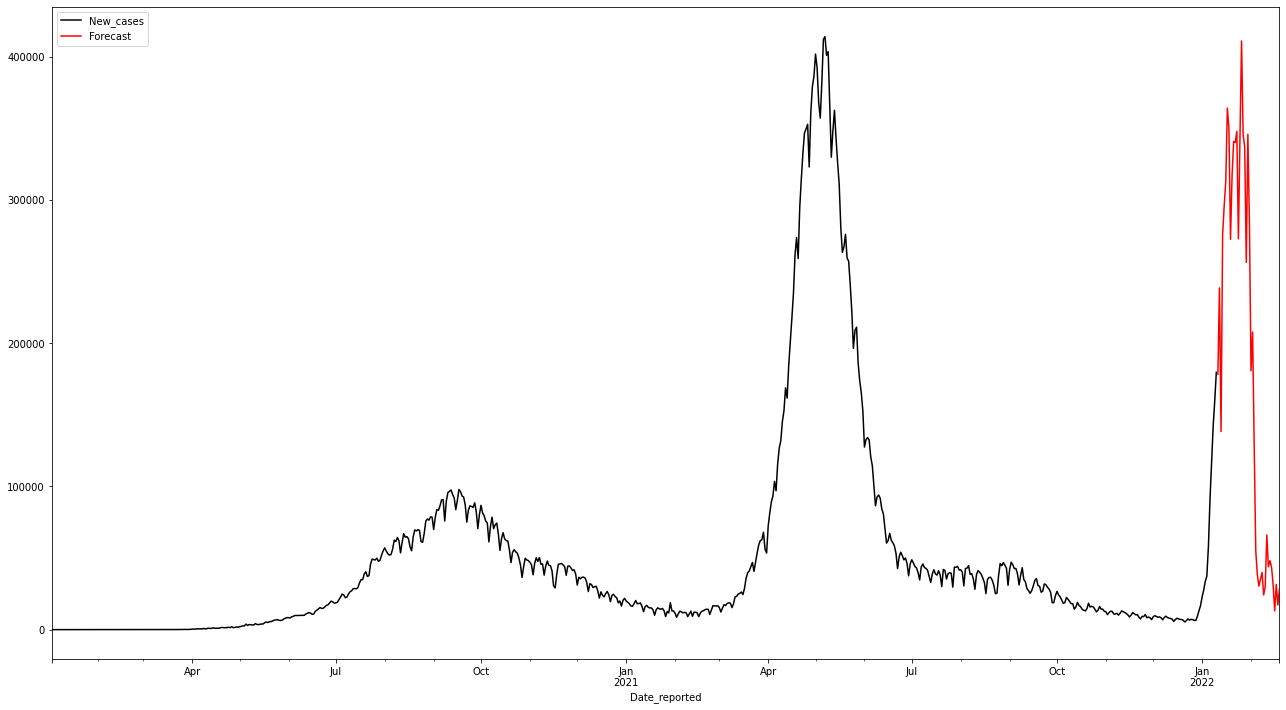

In [63]:
ax = df_cases.plot(figsize=(22,12), color='black') # actual data till 10-01-2022
forecast_df.plot(ax=ax, color='red'); # predicted data from 11-01-2022 till 19-02-2022

## Plot of Actual Third Wave graph Taken from Google

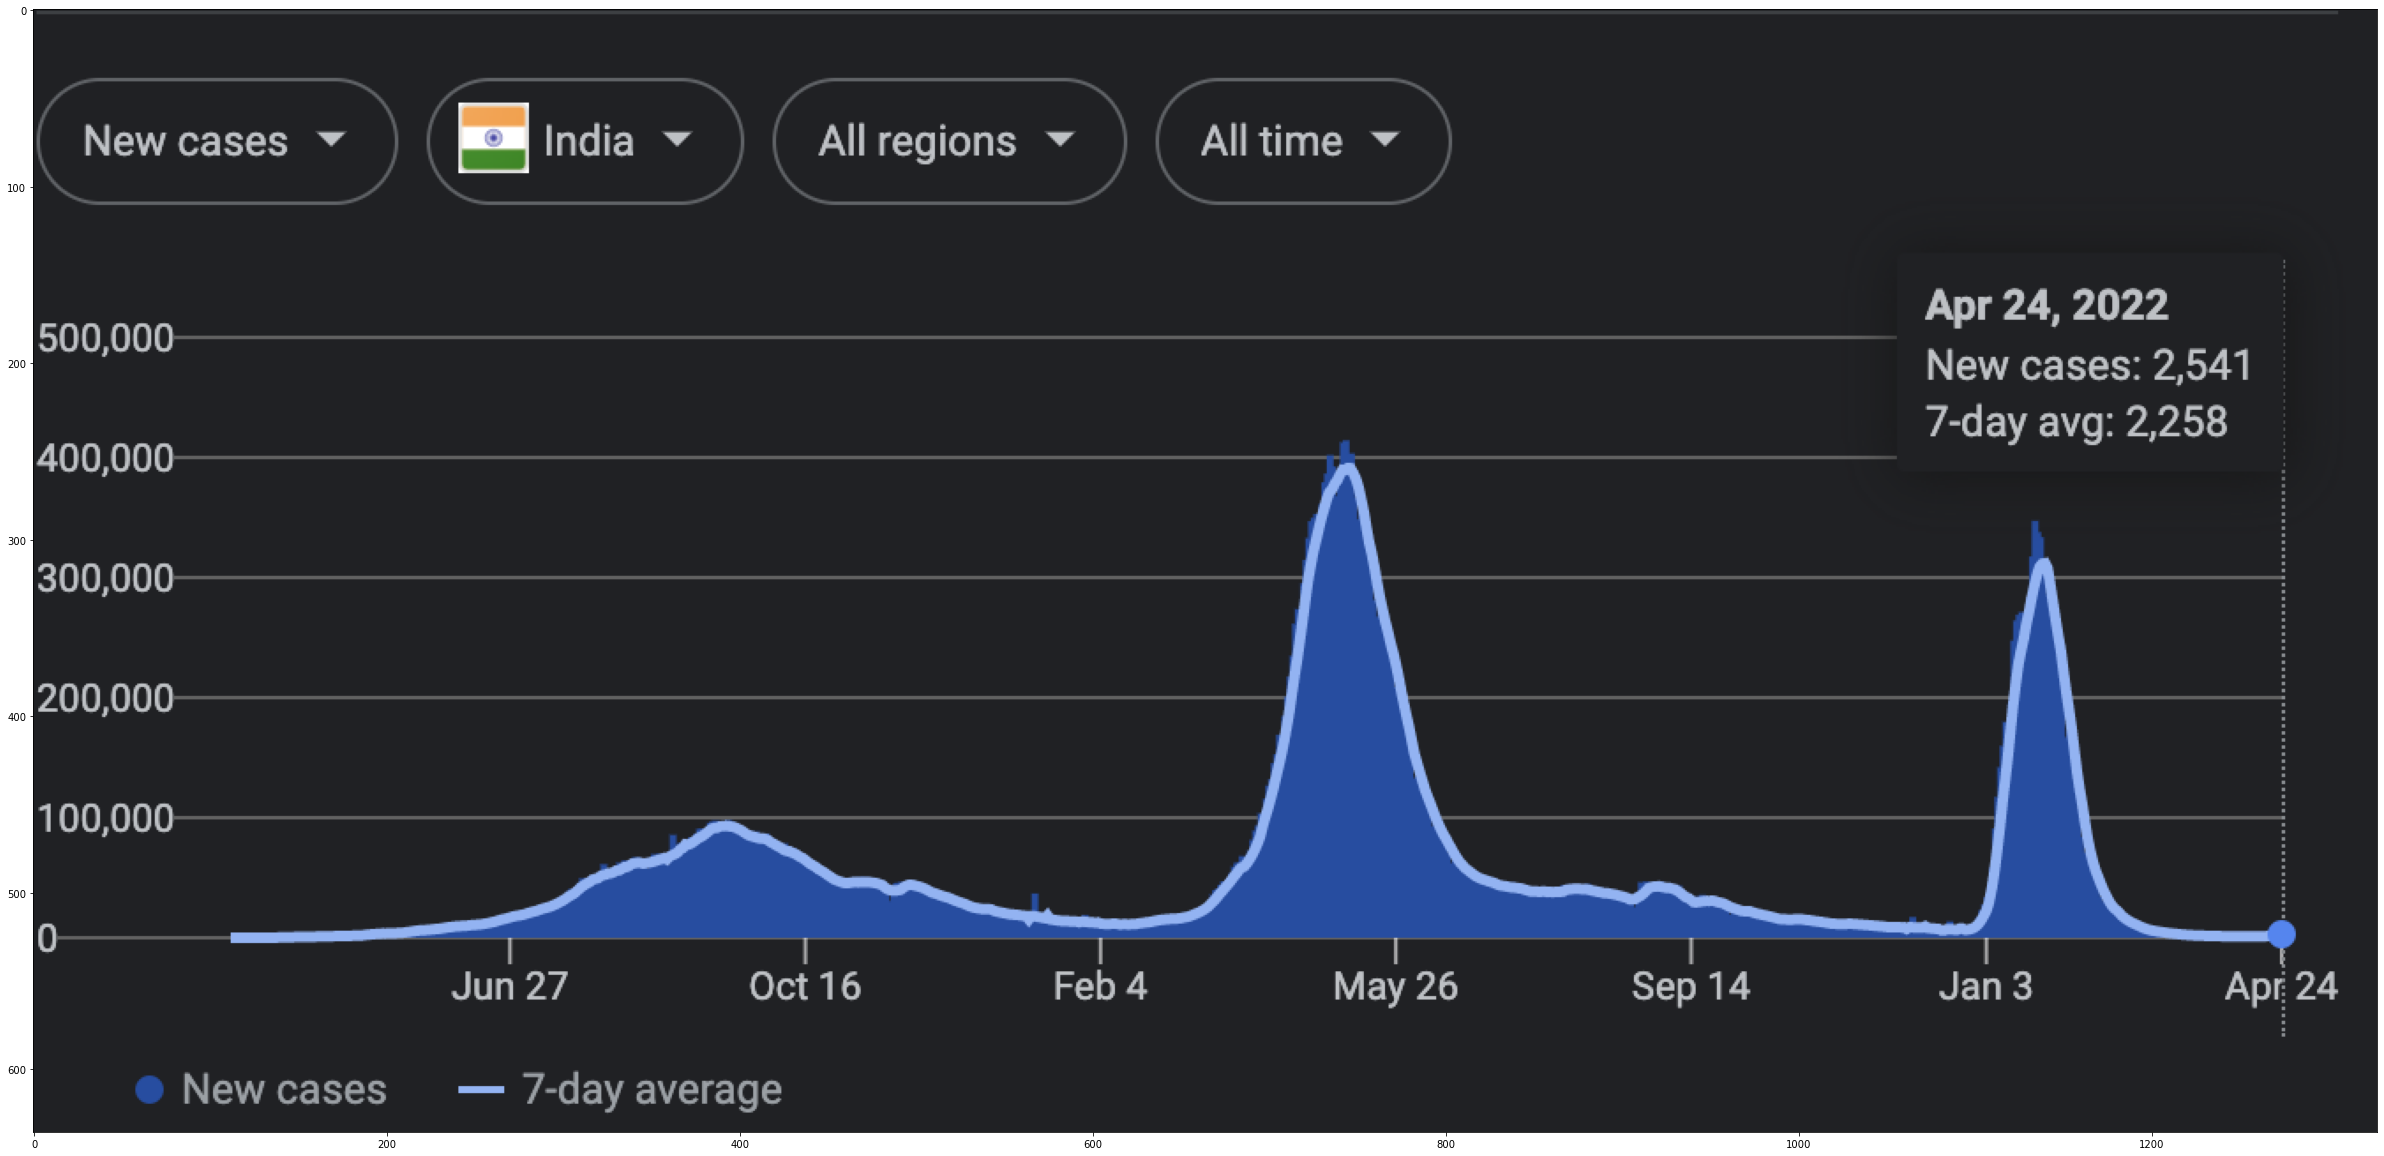

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open("Latest Covid-19 Cases Graph.png")
plt.figure(figsize=(42,22))
plt.imshow(img)